In [1]:
# Import all dependencies

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
tf.random.set_seed(123)
np.random.seed(123)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# read csv in the dataframea

df = pd.read_csv("../ane_energy/df_merged.csv",parse_dates=['dt_start_utc'],index_col='dt_start_utc')

In [3]:
# show if some nans in our dataframe

print(np.any(np.isnan(df)))

False


In [4]:
df.head()

,50Hertz_power_mw_x,DE_power_mw_x,DK_power_mw_x,DK1_power_mw_x,TTG_power_mw_x,total_pred_cons,Wasserkraft,Wind Onshore[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],...,rz_saldo_roll_diff_16_2,epex_diff,epex_roll_win8,epex_roll_win2,epex_roll_diff_16_2,fac_epex_rz_saldo,weekday,businessday,businesshours,rz_saldo_mwh_sign
dt_start_utc,,,,,,,,,,,,,,,,,,,,,
2021-01-01 06:15:00,915.0,2337.0,81.0,41.0,730.0,4104.0,287.0,552.0,56.0,2.036,...,21.2500,0.163778,39.865196,40.007385,0.151559,-966.090674,4,1,1,-1.0
2021-01-01 06:30:00,910.0,2342.0,81.0,41.0,738.0,4112.0,286.0,536.0,56.0,2.036,...,48.5000,0.163052,39.929604,40.171526,-0.083814,-3233.346434,4,1,1,-1.0
2021-01-01 06:45:00,906.0,2352.0,81.0,41.0,748.0,4128.0,286.0,505.0,57.0,2.039,...,20.5000,0.294637,40.054093,40.368019,-0.289428,1058.498157,4,1,1,1.0
2021-01-01 07:00:00,903.0,2363.0,84.0,52.0,759.0,4161.0,287.0,514.0,57.0,2.039,...,-46.1875,0.558532,40.259093,40.663019,-0.529428,2187.310000,4,1,1,1.0
2021-01-01 07:15:00,882.0,2361.0,84.0,52.0,777.0,4156.0,290.0,510.0,57.0,2.039,...,-69.5000,0.822428,40.565033,41.122681,-0.867957,3072.747225,4,1,1,1.0


In [5]:
# lets have a look about our data, how its distributed

df.describe()

,50Hertz_power_mw_x,DE_power_mw_x,DK_power_mw_x,DK1_power_mw_x,TTG_power_mw_x,total_pred_cons,Wasserkraft,Wind Onshore[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],...,rz_saldo_roll_diff_16_2,epex_diff,epex_roll_win8,epex_roll_win2,epex_roll_diff_16_2,fac_epex_rz_saldo,weekday,businessday,businesshours,rz_saldo_mwh_sign
count,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,...,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000,17292.000000
mean,3698.055922,10840.317546,1079.399318,883.551122,4517.622658,21018.946565,422.808293,139.321202,46.721663,1.850000,...,0.063487,0.002172,54.960827,54.966260,-0.018318,-741.250706,2.999075,0.711948,-0.167014,-0.062341
std,3276.629072,8662.920618,921.776306,768.672535,3664.402896,16497.380697,99.381445,279.490393,7.645216,0.179444,...,92.790250,2.010151,22.798248,23.085079,9.030273,6777.661726,2.007590,0.452869,0.985983,0.998084
min,0.000000,164.000000,38.000000,17.000000,74.000000,568.000000,245.000000,1.000000,36.000000,1.210000,...,-492.750000,-14.832536,-68.280946,-69.823217,-48.492249,-55005.470790,0.000000,0.000000,-1.000000,-1.000000
25%,1251.750000,4508.000000,349.000000,276.000000,1678.750000,8891.500000,349.000000,1.835750,39.000000,1.663000,...,-56.390625,-0.974278,44.322083,44.249851,-4.420974,-4154.239821,1.000000,0.000000,-1.000000,-1.000000
50%,2508.500000,7844.000000,771.000000,622.000000,3222.000000,15048.000000,385.000000,3.478000,45.000000,1.925000,...,-1.781250,-0.171360,55.409913,55.319164,1.362473,-316.794967,3.000000,1.000000,-1.000000,-1.000000
75%,5314.000000,14787.750000,1590.250000,1289.000000,6432.000000,28745.250000,512.000000,8.492250,54.000000,2.015000,...,56.062500,0.810108,67.811826,67.849164,5.154478,2889.001714,5.000000,1.000000,1.000000,1.000000
max,14576.000000,39567.000000,4217.000000,3459.000000,15683.000000,75105.000000,686.000000,999.000000,58.000000,2.052000,...,557.500000,15.350845,135.055446,139.949643,37.876499,42943.829639,6.000000,1.000000,1.000000,1.000000


In [6]:
# defined function which preprocesses the data suitable for forecasting

def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [7]:
# cut the last 96 Timestamps data for forecasting

validate = df.tail(96)
df.drop(df.tail(96).index,inplace=True)

In [8]:
# drop the columns we dont need

df_1 = df.drop("rebap_eur_mwh", axis= 1)

In [9]:
# MinMaxScaler to scale down the values. 
# The neural network converges sooner when it exposes the same scaled features and gives better accuracy

x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df_1)
dataY = y_scaler.fit_transform(df[['rebap_eur_mwh']])

In [10]:
# As we are doing multiple-step forecasting, 
# let’s allow the model to see past 384 hours of data and forecast the 96 hrs after data; 
# for that, we set the horizon to 96.

hist_window = 384
horizon = 96
TRAIN_SPLIT = 10000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [11]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.06277442 0.05514809 0.01028954 ... 1.         1.         0.        ]
 [0.06243139 0.05527498 0.01028954 ... 1.         1.         0.        ]
 [0.06215697 0.05552877 0.01028954 ... 1.         1.         1.        ]
 ...
 [0.21905873 0.27256808 0.31371141 ... 1.         1.         0.        ]
 [0.21974479 0.27091846 0.31371141 ... 1.         1.         1.        ]
 [0.22043085 0.26957338 0.30988275 ... 1.         1.         1.        ]]

 Target horizon
[[0.33760444]
 [0.36000021]
 [0.35908349]
 [0.35965041]
 [0.36067396]
 [0.36697207]
 [0.34591519]
 [0.356821  ]
 [0.35777907]
 [0.34939423]
 [0.36367396]
 [0.36040342]
 [0.36099446]
 [0.36611738]
 [0.36294162]
 [0.37033048]
 [0.37528109]
 [0.36526443]
 [0.37073887]
 [0.36544019]
 [0.36474403]
 [0.36187672]
 [0.36066362]
 [0.35984685]
 [0.36170268]
 [0.35944535]
 [0.40173659]
 [0.36634312]
 [0.36615012]
 [0.36213691]
 [0.36098412]
 [0.36111681]
 [0.36132186]
 [0.34417826]
 [0.35911106]
 [0.3602897 ]
 [0.3

In [13]:
# Prepare the training data and validation data using the TensorFlow data function, 
# which faster and efficient way to feed data for training.

BATCH_SIZE = 16
BUFFER_SIZE = 4

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [14]:
# Build and compile the model

model = Sequential()
model.add(Conv1D(filters=640, kernel_size=3, activation='relu', input_shape=(x_train_multi.shape[1], x_train_multi.shape[2])))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(horizon))
model.compile(optimizer='adam', loss='mse')

In [15]:
# save model

model_path = r'\Chapter_7\CNN_Multivariate.h5"

In [16]:
# train the model

EVALUATION_INTERVAL = 150
EPOCHS = 150
history = model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
150/150 [==============================] - 11s 44ms/step - loss: 0.1852 - val_loss: 0.0650
Epoch 2/150
150/150 [==============================] - 4s 25ms/step - loss: 0.0447 - val_loss: 0.0265
Epoch 3/150
150/150 [==============================] - 3s 18ms/step - loss: 0.0168 - val_loss: 0.0092
Epoch 4/150
150/150 [==============================] - 2s 12ms/step - loss: 0.0065 - val_loss: 0.0027
Epoch 5/150
150/150 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 7.9058e-04
Epoch 6/150
150/150 [==============================] - 2s 10ms/step - loss: 6.6214e-04 - val_loss: 2.8249e-04
Epoch 7/150
150/150 [==============================] - 2s 11ms/step - loss: 1.7703e-04 - val_loss: 1.6857e-04
Epoch 8/150
150/150 [==============================] - 2s 11ms/step - loss: 8.1094e-04 - val_loss: 1.4727e-04
Epoch 9/150
150/150 [==============================] - 2s 11ms/step - loss: 3.0612e-04 - val_loss: 1.4119e-04
Epoch 10/150
150/150 [=======================

In [17]:
# Load the saved model

Trained_model = tf.keras.models.load_model(model_path)

In [18]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 382, 640)          140800    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 191, 640)          0         
_________________________________________________________________
dropout (Dropout)            (None, 191, 640)          0         
_________________________________________________________________
flatten (Flatten)            (None, 122240)            0         
_________________________________________________________________
dense (Dense)                (None, 30)                3667230   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                2

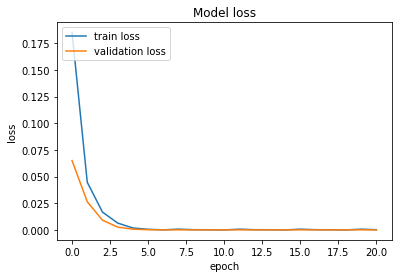

In [19]:
# plot our train and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [20]:
# Prepare the testing data for the last 384 hrs and check the prediction against it
# by visualizing the actual and predicted values. 

data_val = x_scaler.fit_transform(df_1.tail(384))

In [21]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [22]:
Predicted_results = Trained_model.predict(val_rescaled)

In [23]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [24]:
Predicted_results_Inv_trans

array([[48.5604  , 48.754276, 48.63321 , 48.53238 , 48.698067, 48.73906 ,
        48.505573, 48.55711 , 48.530304, 48.749607, 48.658806, 48.50782 ,
        48.76725 , 48.661404, 48.531513, 48.342823, 45.558804, 48.57527 ,
        48.740097, 48.605194, 48.733696, 48.65483 , 48.749954, 48.563858,
        48.573887, 48.573887, 48.64082 , 48.63217 , 48.574406, 48.749435,
        48.57977 , 48.596718, 48.601906, 47.538593, 48.744766, 48.75082 ,
        48.606056, 48.558666, 48.54881 , 48.54293 , 47.085804, 48.54016 ,
        48.633385, 48.61903 , 47.713966, 48.54829 , 48.54466 , 48.495888,
        48.648087, 48.491043, 48.628197, 48.687862, 48.7164  , 48.492775,
        48.456627, 48.4229  , 48.649986, 47.498814, 48.510067, 48.415638,
        48.625774, 48.414772, 48.406296, 48.43916 , 48.584957, 48.405952,
        48.390903, 41.04664 , 48.371532, 48.47911 , 47.88104 , 48.475998,
        48.320168, 48.328987, 48.543793, 48.5476  , 48.260845, 48.513874,
        48.28765 , 48.4843  , 48.52667

In [25]:
# Finally, evaluate the result with standard performance metrics.

from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [26]:
# Results of the metrics

timeseries_evaluation_metrics_func(validate['rebap_eur_mwh'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 7606.961663606436
MAE is : 72.76558035850525
RMSE is : 87.21789761056176
MAPE is : 87.63955876831233
R2 is : -0.8872713005901571



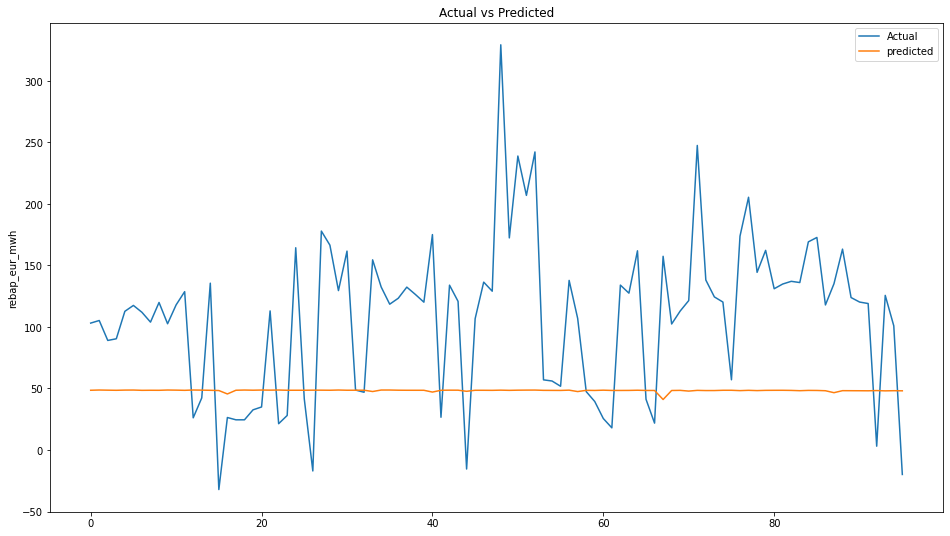

In [27]:
# Plot the actual vs predicted data

plt.plot(list(validate['rebap_eur_mwh']))
plt.plot(list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("rebap_eur_mwh")
plt.legend(('Actual','predicted'))
plt.show()